# 450 Birds Classification

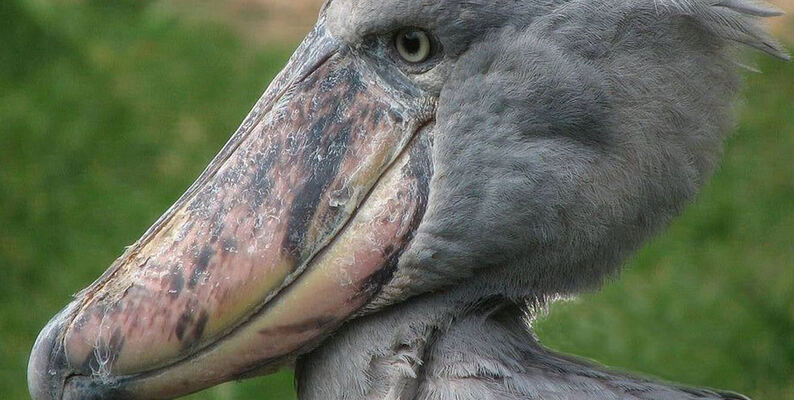

<b>About Dataset</b>
- Data set of 450 bird species. 70,626 training images, 22500 test images(5 images per species) and 2250 validation images(5 images per species. This is a very high quality dataset where there is only one bird in each image and the bird typically takes up at least 50% of the pixels in the image.

In [1]:
import os
import glob
import json
import random
import shutil
from PIL import Image
import numpy as np
import requests
import cv2
import random
import shutil
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from pandas.core.common import flatten
from tqdm import tqdm
from IPython import display
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor, Resize
from torchvision import datasets, transforms, models, utils
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
import warnings
import json
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np 


warnings.filterwarnings('ignore')
%matplotlib inline

plt.ion()   # interactive mode

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


- The number of each category is not balanced, so the f1 score is used as the indicator

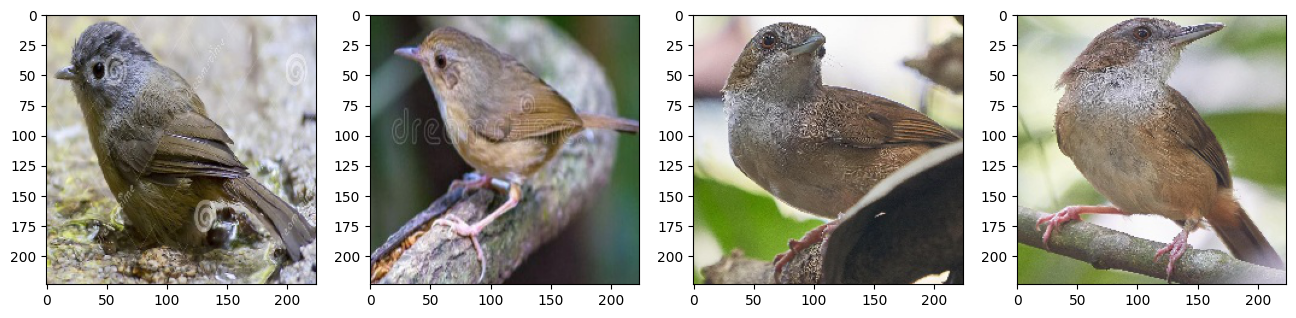

In [2]:
plt.figure(figsize=(16, 4))
for i in range(1, 5):
    path = f'./birds/train/ABBOTTS BABBLER/00{i}.jpg'
    img = Image.open(path)
    plt.subplot(1, 4, i)
    plt.imshow(img)

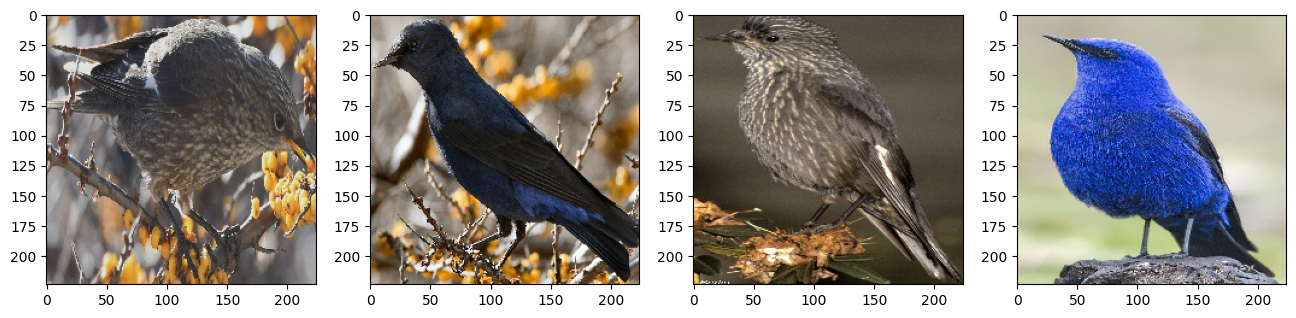

In [3]:
plt.figure(figsize=(16, 4))
for i in range(1, 5):
    path = f'./birds/train/GRANDALA/00{i}.jpg'
    img = Image.open(path)
    plt.subplot(1, 4, i)
    plt.imshow(img)

# prepare dataset for training teacher model

- This dataset is about 2GB, and it may take days or more to train the model directly from scratch, so I use transfer learning to reduce the training time
- I use huggingface's convnext xlarge model as a teacher model to see how many f1 values can be achieved
- Then use the tiny model to see if the performance drops slightly
- Finally, use tiny model training alone to see the difference in performance

In [2]:
data_files={'train': ['./birds/train**'],
            'val': ['./birds/val**'],
            'test': ['./birds/test**']}
dataset = load_dataset("imagefolder", data_files=data_files)
labels = dataset['train'].features['label'].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}
print(id2label)
print(label2id)

Resolving data files:   0%|          | 0/70626 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2250 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2250 [00:00<?, ?it/s]

Using custom data configuration default-6d7e20b9f783a5df
Reusing dataset imagefolder (C:\Users\hon20\.cache\huggingface\datasets\imagefolder\default-6d7e20b9f783a5df\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff)


  0%|          | 0/3 [00:00<?, ?it/s]

{0: 'ABBOTTS BABBLER', 1: 'ABBOTTS BOOBY', 2: 'ABYSSINIAN GROUND HORNBILL', 3: 'AFRICAN CROWNED CRANE', 4: 'AFRICAN EMERALD CUCKOO', 5: 'AFRICAN FIREFINCH', 6: 'AFRICAN OYSTER CATCHER', 7: 'AFRICAN PIED HORNBILL', 8: 'ALBATROSS', 9: 'ALBERTS TOWHEE', 10: 'ALEXANDRINE PARAKEET', 11: 'ALPINE CHOUGH', 12: 'ALTAMIRA YELLOWTHROAT', 13: 'AMERICAN AVOCET', 14: 'AMERICAN BITTERN', 15: 'AMERICAN COOT', 16: 'AMERICAN FLAMINGO', 17: 'AMERICAN GOLDFINCH', 18: 'AMERICAN KESTREL', 19: 'AMERICAN PIPIT', 20: 'AMERICAN REDSTART', 21: 'AMERICAN WIGEON', 22: 'AMETHYST WOODSTAR', 23: 'ANDEAN GOOSE', 24: 'ANDEAN LAPWING', 25: 'ANDEAN SISKIN', 26: 'ANHINGA', 27: 'ANIANIAU', 28: 'ANNAS HUMMINGBIRD', 29: 'ANTBIRD', 30: 'ANTILLEAN EUPHONIA', 31: 'APAPANE', 32: 'APOSTLEBIRD', 33: 'ARARIPE MANAKIN', 34: 'ASHY STORM PETREL', 35: 'ASHY THRUSHBIRD', 36: 'ASIAN CRESTED IBIS', 37: 'ASIAN DOLLARD BIRD', 38: 'AUCKLAND SHAQ', 39: 'AUSTRAL CANASTERO', 40: 'AUSTRALASIAN FIGBIRD', 41: 'AVADAVAT', 42: 'AZARAS SPINETAIL', 43

In [5]:
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-xlarge-224-22k")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-xlarge-224-22k",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 2048]) in the checkpoint and torch.Size([450, 2048]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([450]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-xlarge-224-22k")
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([RandomResizedCrop(feature_extractor.size),
                     RandomHorizontalFlip(),
                     ToTensor(),
                     normalize])

def train_transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

processed_dataset = dataset.with_transform(train_transforms)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(processed_dataset["train"], collate_fn=collate_fn, batch_size=2, shuffle=True)
val_dataloader = DataLoader(processed_dataset["val"], collate_fn=collate_fn, batch_size=2, shuffle=True)

batch = next(iter(train_dataloader))
batch['pixel_values'].shape, batch['labels'].shape

(torch.Size([2, 3, 224, 224]), torch.Size([2]))

In [5]:
def train_single_model(model, train_dataloader, train_metric, mode='convnext'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
    m = torch.nn.Softmax(dim=1)
    criterion = nn.CrossEntropyLoss()
    model.to(device).train()
    correct = 0
    total = 0
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # move batch to GPU
        batch = {k:v.to(device) for k,v in batch.items()}
        y_true = batch["labels"]
        optimizer.zero_grad()

        # forward pass
        if mode == 'convnext':
            outputs = model(pixel_values=batch["pixel_values"], 
                            labels=y_true)
            loss, logits = outputs.loss, outputs.logits
        else:
            logits = model(batch["pixel_values"])
            loss = criterion(logits, y_true)
                
        loss.backward()
        optimizer.step()
        
        # metrics
        total += batch["labels"].shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()
        accuracy = correct/total
        
        
        logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
        predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
        y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))
        
        if idx % 100 == 0:
            print(f"Loss after {idx} steps:", loss.item())
            print(f"Accuracy after {idx} steps:", accuracy)
    
    # metrics
    y_score = m(logits_).detach().cpu().numpy()
    y_true = y_true_.detach().cpu().numpy()
    y_pred = predicted_.detach().cpu().numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted') # sensitivity
    f1_score = 2 / (1 / precision + 1 / recall)
    
    train_metric['precision'].append(precision)
    train_metric['recall'].append(recall)
    train_metric['loss'].append(loss.item())
    train_metric['acc'].append(accuracy)
    train_metric['f1_score'].append(accuracy)
    
    print(f"Train: acc: {accuracy}, f1_score: {f1_score}")
    return model, train_metric

In [6]:
def eval_single_model(model, val_dataloader, val_metric, mode='convnext'):
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss()
    m = torch.nn.Softmax(dim=1)
    model.to(device).eval() # eval mode
    print('validating:')
    
    for idx, batch in enumerate(tqdm(val_dataloader)):
        batch = {k:v.to(device) for k,v in batch.items()}
        y_true = batch["labels"]
        with torch.no_grad():
            if mode == 'convnext':
                outputs = model(pixel_values=batch["pixel_values"], 
                                labels=y_true)
                loss, logits = outputs.loss, outputs.logits
            else:
                logits = model(batch["pixel_values"])
                loss = criterion(logits, y_true)
        
        # metrics
        total += y_true.shape[0]
        predicted = logits.argmax(-1)
        correct += (predicted == y_true).sum().item()
        accuracy = correct/total
        
        logits_ = logits if idx == 0 else torch.vstack((logits_, logits))
        predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
        y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))
    
    # metrics
    y_score = m(logits_).detach().cpu().numpy()
    y_true = y_true_.detach().cpu().numpy()
    y_pred = predicted_.detach().cpu().numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted') # sensitivity
    f1_score = 2 / (1 / precision + 1 / recall)

    val_metric['precision'].append(precision)
    val_metric['recall'].append(recall)
    val_metric['f1_score'].append(f1_score)
    val_metric['loss'].append(loss.item())
    val_metric['acc'].append(accuracy)
    
    print(f"val: acc: {accuracy}, f1_score: {f1_score}")
    return val_metric

In [7]:
def plot_graph(train_metric, val_metric):
    display.clear_output()
    n = len(train_metric['acc'])
    plt.figure(figsize=(20, 6))
    plt.subplot(1, 5, 1)
    plt.plot(range(1, n+1), train_metric['acc'], label='train_acc')
    plt.plot(range(1, n+1), val_metric['acc'], label='val_acc')
    plt.grid()
    plt.legend()

    plt.subplot(1, 5, 2)
    plt.plot(range(1, n+1), train_metric['loss'], label='train_loss')
    plt.plot(range(1, n+1), val_metric['loss'], label='val_loss')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 5, 3)
    plt.plot(range(1, n+1), train_metric['precision'], label='train_precision')
    plt.plot(range(1, n+1), val_metric['precision'], label='val_precision')
    plt.legend()
    plt.grid()
    
    plt.subplot(1, 5, 4)
    plt.plot(range(1, n+1), train_metric['recall'], label='train_recall')
    plt.plot(range(1, n+1), val_metric['recall'], label='val_recall')
    plt.legend()
    plt.grid()

    plt.subplot(1, 5, 5)
    plt.plot(range(1, n+1), train_metric['f1_score'], label='train_f1_score')
    plt.plot(range(1, n+1), val_metric['f1_score'], label='val_f1_score')
    plt.legend()
    plt.grid()
    plt.show()

# train teacher model

In [ ]:
train_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}
val_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}


for epoch in range(1, 6):
    print("Epoch:", epoch)
    model, train_metric = train_single_model(model, train_dataloader, train_metric, mode='convnext')
    
    PATH = f"./xlarge_model_221117_epoch_{epoch}.pt"
    torch.save(model.state_dict(), PATH)
    
    # eval
    val_metric = eval_single_model(model, val_dataloader, val_metric, mode='convnext')
    
    with open("train_xlarge_1110.json", "w") as outfile:
        json.dump(train_metric, outfile)

    with open("val_xlarge_1110.json", "w") as outfile:
        json.dump(val_metric, outfile)

    # plot
    plot_graph(train_metric, val_metric)

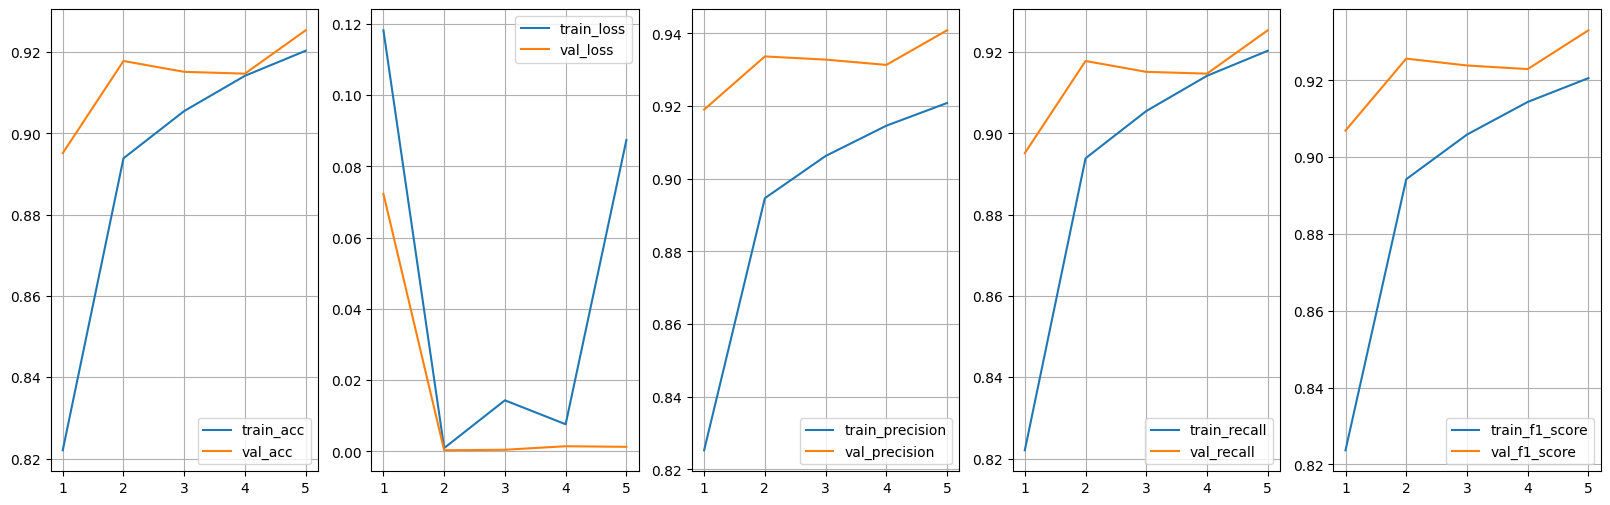

In [37]:
with open("./model/old/train_xlarge_1110.json", "r") as outfile:
    train_metric = json.load(outfile)

with open("./model/old/val_xlarge_1110.json", "r") as outfile:
    val_metric = json.load(outfile)

plot_graph(train_metric, val_metric)

In [39]:
val_metric['f1_score']

[0.9069062702086643,
 0.9256471097283626,
 0.923861291298041,
 0.9229195663223384,
 0.9330276357946489]

<b>result of training xlarge model</b>
- The model has no obvious overfitting, but it took long time(18 hours) to train for 5 rounds, so the 5th round(epoch=5) is used as the best model
- The f1 score of validating set is about 0.933
- It seems that the xlarge model could get higher f1 score if it trains more epochs.

# test teacher model

In [32]:
from transformers import ConvNextFeatureExtractor
from transformers import AutoModelForImageClassification
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor
import torch 
from torch.utils.data import DataLoader
#from tqdm.notebook import tqdm
from tqdm import tqdm
from IPython import display
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np 
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
import random
import shutil
from tqdm import tqdm
from transformers import ConvNextFeatureExtractor, ConvNextModel
import torch
from datasets import load_dataset
import json
from transformers import ConvNextFeatureExtractor
from transformers import AutoModelForImageClassification
from torchvision.transforms import Compose, Normalize, RandomHorizontalFlip, RandomResizedCrop, ToTensor
import torch 
from torch.utils.data import DataLoader
#from tqdm.notebook import tqdm
from tqdm import tqdm
from IPython import display

import matplotlib.pyplot as plt
from datasets import load_dataset
import os
import random
import shutil
from transformers import ConvNextFeatureExtractor, ConvNextForImageClassification
import torch
from datasets import load_dataset

In [33]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

def train_transforms(examples):
    examples["pixel_values"] = [transform(image.convert("RGB")) for image in examples["image"]]
    return examples

# we can load a custom dataset using the "imagefolder" feature
# details: https://huggingface.co/docs/datasets/image_process#imagefolder
device = "cuda" if torch.cuda.is_available() else "cpu"

data_files={'test': ['./birds/test**']}
dataset = load_dataset("imagefolder", data_files=data_files)
labels = dataset['test'].features['label'].names
id2label = {k:v for k,v in enumerate(labels)}
label2id = {v:k for k,v in enumerate(labels)}

feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-xlarge-224-22k")
normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose(
    [
     RandomResizedCrop(feature_extractor.size),
     RandomHorizontalFlip(),
     ToTensor(),
     normalize
    ]
)

processed_dataset = dataset.with_transform(train_transforms)
test_dataloader = DataLoader(processed_dataset["test"], collate_fn=collate_fn, batch_size=16, shuffle=False)

Resolving data files:   0%|          | 0/2250 [00:00<?, ?it/s]

Using custom data configuration default-f8b74603565ee179


Extracting data files: 0it [00:00, ?it/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to C:\Users\hon20\.cache\huggingface\datasets\imagefolder\default-f8b74603565ee179\0.0.0\0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
path = "./model/xlarge_model_221110_epoch_4.pt"
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-xlarge-224-22k",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)
model.load_state_dict(torch.load(path))

test_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}
test_metric = eval_single_model(model, test_dataloader, test_metric, mode='convnext')

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-xlarge-224-22k and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([21841, 2048]) in the checkpoint and torch.Size([450, 2048]) in the model instantiated
- classifier.bias: found shape torch.Size([21841]) in the checkpoint and torch.Size([450]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


validating:


100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [01:02<00:00,  2.24it/s]

val: acc: 0.9346666666666666, f1_score: 0.9419711253325695


<b>result of evaluation</b>
- The f1 score of test set is about  0.942,  it is good

# train pretrained tiny model with knowledge distillation

In [89]:
def train_KD_model(teacher_model, student_model, train_dataloader, train_metric, alpha, temperature, mode='convnext'):
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=5e-5)
    criterion = nn.CrossEntropyLoss()
    m = torch.nn.Softmax(dim=1)
    teacher_model.to(device).eval()
    student_model.to(device).train()
    correct = 0
    total = 0
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # move batch to GPU
        batch = {k:v.to(device) for k,v in batch.items()}
        optimizer.zero_grad()

        # forward pass
        loss, student_logits = error_and_output(teacher_model, student_model, 
                                                batch["pixel_values"], batch["labels"], 
                                                alpha, temperature, mode='resnet')
        loss.backward()
        optimizer.step()

        # metrics
        total += batch["labels"].shape[0]
        predicted = student_logits.argmax(-1)
        correct += (predicted == batch["labels"]).sum().item()
        accuracy = correct / total

        y_true = batch["labels"]
        student_logits_ = student_logits if idx == 0 else torch.vstack((student_logits_, student_logits))
        predicted_ = predicted if idx == 0 else torch.hstack((predicted_, predicted))
        y_true_ = y_true if idx == 0 else torch.hstack((y_true_, y_true))

        if idx % 100 == 0:
            print(f"Loss after {idx} steps:", loss.item())
            print(f"Accuracy after {idx} steps:", accuracy)
    
    # metrics
    y_score = m(student_logits_).detach().cpu().numpy()
    y_true = y_true_.detach().cpu().numpy()
    y_pred = predicted_.detach().cpu().numpy()
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted') # sensitivity
    f1_score = 2 / (1 / precision + 1 / recall)

    print(f"Train: accuracy: {accuracy}, f1_score: {f1_score}")
    train_metric['precisioncision'].append(precision)
    train_metric['recall'].append(recall)
    train_metric['loss'].append(loss.item())
    train_metric['acc'].append(accuracy)
    train_metric['f1_score'].append(f1_score)

    return student_model, train_metric

In [86]:
def error_and_output(teacher_model, student_model, var_X_batch, var_y_batch, alpha, temperature, mode='convnext'): # create loss function
    # Kullback-Leibler Divergence is used to calc cross-entropy between answers of models
    kldloss = nn.KLDivLoss()  
    # Regular cross-entropy
    celoss = nn.CrossEntropyLoss()
    
    teacher_outputs = teacher_model(pixel_values=var_X_batch, labels=var_y_batch)
    if mode == 'convnext':
        student_outputs = student_model(pixel_values=var_X_batch, labels=var_y_batch)
        student_loss, student_logits = student_outputs.loss, student_outputs.logits
    else:
        student_logits = student_model(var_X_batch)
    
    teacher_loss, teacher_logits = teacher_outputs.loss, teacher_outputs.logits

    # softmax with temperature T for student network
    soft_predictions = F.log_softmax( student_logits / temperature, dim=1 )
    # and for teacher network
    soft_labels = F.softmax( teacher_logits / temperature, dim=1 )
    # distillation loss
    distillation_loss = kldloss(soft_predictions, soft_labels)

    # regular loss
    student_loss = celoss(student_logits, var_y_batch)
    
    # sum-up
    KD_loss = distillation_loss * alpha + student_loss * (1 - alpha), student_logits
    return KD_loss

In [ ]:
import json
from sklearn.metrics import precision_score, recall_score, roc_auc_score
import numpy as np 

    
train_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}
val_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}

alpha=0.5
temperature=2
for epoch in range(1, 6):
    print("Epoch:", epoch)
    student_model, train_metric = train_KD_model(teacher_model, student_model, train_dataloader, 
                                         train_metric, alpha, temperature, mode='convnext')
    
    PATH = f"./tiny_model_221110_epoch_{epoch}.pt"
    torch.save(student_model.state_dict(), PATH)
    
    # eval
    val_metric = eval_single_model(student_model, val_dataloader, val_metric, mode='convnext')
    
    with open("train_tiny_kd_1110.json", "w") as outfile:
        json.dump(train_metric, outfile)

    with open("val_tiny_kd_1110.json", "w") as outfile:
        json.dump(val_metric, outfile)

    # plot
    plot_graph(train_metric, val_metric)

I lost my training record, so I load the teacher model and all student models to eval with train/val set to get the result again.
- the best teacher model is epoch = 5, val_f1_score = 0.933, test_f1_score = 0.942

In [ ]:
path = "./model/xlarge_model_221110_epoch_5.pt"
teacher_model = ConvNextForImageClassification.from_pretrained("facebook/convnext-xlarge-224-22k",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)
teacher_model.load_state_dict(torch.load(path))

In [87]:
student_model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([450, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([450]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


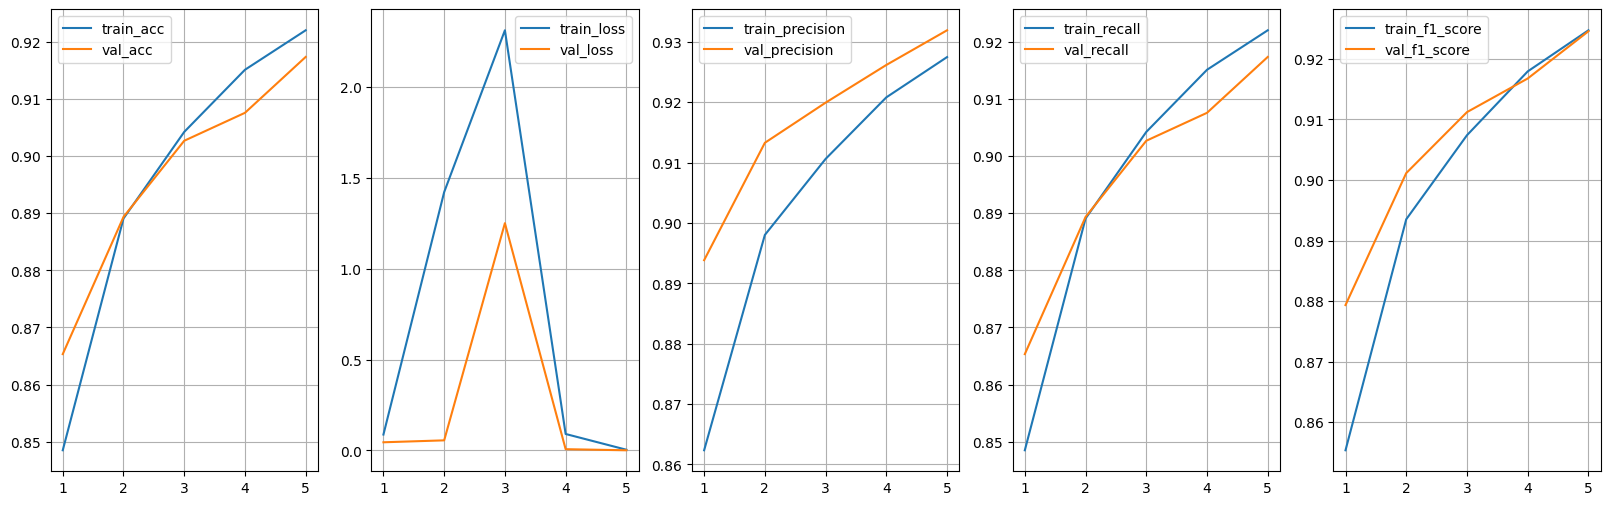

In [88]:
train_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}
val_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}

for epoch in range(1, 6):
    print("Epoch:", epoch)
    path = f"./model/old/tiny_model_221110_epoch_{epoch}.pt"
    student_model.load_state_dict(torch.load(path))
    train_metric = eval_single_model(student_model, train_dataloader, train_metric, mode='convnext')
    
    # eval
    val_metric = eval_single_model(student_model, val_dataloader, val_metric, mode='convnext')
    
    with open("train_tiny_kd_1117.json", "w") as outfile:
        json.dump(train_metric, outfile)

    with open("val_tiny_kd_1117.json", "w") as outfile:
        json.dump(val_metric, outfile)

    # plot
    plot_graph(train_metric, val_metric)

In [91]:
val_metric['f1_score']

[0.8793470219249624,
 0.9011390931957954,
 0.9112060820933401,
 0.9167606174414606,
 0.9245581664463548]

Here we can find that the student model is still making progress. Because of the time, there are only 5 rounds of training here, and the results of the 5th round are the best. the val_f1_score = 0.925

# test pretrained tiny model with knowledge distillation

In [92]:
test_metric = {'precision': [], 'recall': [], 'loss': [], 'acc': [], 'f1_score': []}
test_metric = eval_single_model(student_model, test_dataloader, test_metric, mode='convnext')

validating:


100%|████████████████████████████████████████████████████████████████████████████████| 141/141 [00:20<00:00,  6.79it/s]

val: acc: 0.924, f1_score: 0.9307905550868794


compare with teacher model, student model is almost the same performance!
- teacher model: val_f1_score = 0.933, test_f1_score = 0.942
- student model: val_f1_score = 0.925, test_f1_score = 0.931

# predict 1 image

In [109]:
feature_extractor = ConvNextFeatureExtractor.from_pretrained("facebook/convnext-xlarge-224-22k")
model = ConvNextForImageClassification.from_pretrained("facebook/convnext-tiny-224",
                                                        num_labels=len(labels),
                                                        id2label=id2label,
                                                        label2id=label2id,
                                                        ignore_mismatched_sizes=True)

Some weights of ConvNextForImageClassification were not initialized from the model checkpoint at facebook/convnext-tiny-224 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([450, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([450]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [110]:
path = f'./model/tiny_model_221110_epoch_5.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [112]:
img_path = './kiwi.jpg'
img = Image.open(img_path)
transform = Compose([Resize((224, 224)),
                     ToTensor(),
                     normalize])
img = transform(img.convert("RGB"))
img = img.unsqueeze(dim=0)
outputs = model(img)['logits'].argmax(-1).item()
y_pred = id2label[outputs]
y_pred

'KIWI'

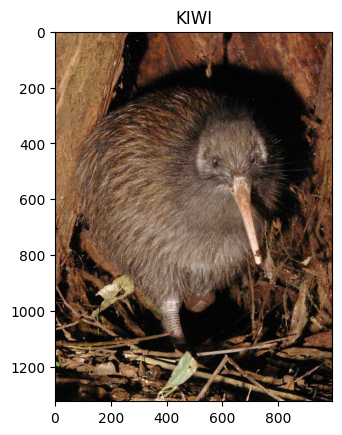

In [116]:
img_path = './kiwi.jpg'
img = Image.open(img_path)
plt.title(f'{y_pred}')
plt.imshow(img)

# Summary

<b>xlarge model</b>
- When using a xlarge Convnext model for training, it can be seen that there is not obvious overfitting. But the training time is very long, so only 5 rounds of training in total, According to the loss, use epoch=5 as the best model. the f1_score on testing set is about 0.9420.

<b>tiny model</b>
- Then I use the xlarge model to teach the tiny model, at epoch=5 as the best model, the f1_score on testing set is about 0.931, dropped by 1% performance.

<b>The effect of knowledge distillation</b>
- the size of xlarge model is 1,363MB, and the size of tiny model is 110MB, Effectively reduces the size by 92%

<b>Online deployment</b>
- I will build a website with flask framework, the user uploads a bird image, use the tiny model to display the most likely species of the image.

.<b>result of evaluation</b>
- The student f1 score of testing set is about 0.931, good enough as a small model for a website.